during the ETLT
1. combine both motorist and sgcarmart
2. names to be extracted -> brand and model 
3. fetch data from API
4. combine both APIs together to get 1 dataset
5. derive the vehicle classes
6. fetch the COE prices

In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from google.cloud import bigquery
pd.set_option('display.max_columns', None)

In [338]:
# read dataset first
# data = pd.read_csv('../Datasets/final_combined_dataset.csv')

path_to_private_key = 'is3107-418903-a6116d294003.json'
bigquery_client = bigquery.Client.from_service_account_json(json_credentials_path=path_to_private_key)

sql = """
        SELECT * FROM `is3107-418903.final.carsCombinedFinal`
        """
data = bigquery_client.query(sql).to_dataframe()

In [339]:
data = data.dropna()

In [340]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,accessories,model_make_id,make,model_trim,model_year,model_body,model_seats,model_weight_kg,model_engine_fuel,model_engine_cyl,model_drive,model_transmission_type,model_fuel_cap_l,vehicle_class
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,- Volk racing Rays Japan ZE40 bronze 17” compl...,408,MAZDA,19992,2016,SUV,5,1338.775510,regular unleaded,I4,all wheel drive,6-speed shiftable automatic,45.0415,B
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,S Line Interior With Nappa Leather Sport Seats...,7,AUDI,9293,2019,SUV,5,1839.909297,premium unleaded (recommended),I4,all wheel drive,7-speed automated manual,70.0225,B
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,"Original BMW sport rims, factory audio with BM...",147,BMW,12432,2018,SUV,5,1606.802721,premium unleaded (recommended),I4,front wheel drive,8-speed shiftable automatic,60.9385,B
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,"Burple and pops M-sport exhaust, M Sport brake...",148,BMW,12437,2018,SUV,5,1939.682540,premium unleaded (recommended),I6,all wheel drive,8-speed shiftable automatic,65.1020,B
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,"Auto Head Lights, Electric Folding Side Mirror...",148,BMW,18443,2016,SUV,5,1827.664399,premium unleaded (required),I4,rear wheel drive,8-speed shiftable automatic,66.9945,B
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,"19"" rims, BMW iDrive navi and Bluetooth, Sunro...",151,BMW,18459,2016,SUV,5,2351.473923,premium unleaded (required),V8,all wheel drive,8-speed shiftable automatic,84.7840,B
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,"Cruise control, keyless entry start, leather s...",363,TOYOTA,11867,2019,SUV,5,1496.598639,regular unleaded,I4,front wheel drive,continuously variable-speed automatic,49.9620,B
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,"16"" Sports Rims, Leather Seats, Factory Fitted...",40,Honda,13526,2018,SUV,5,1322.902494,regular unleaded,I4,front wheel drive,6-speed manual,49.9620,A
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,"Keyless start/stop, Reverse camera. Wireless p...",257,KIA,16895,2017,SUV,5,1433.560091,regular unleaded,I4,front wheel drive,6-speed automated manual,45.0415,B
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,"Bose speakers, adaptive cruise control, rear c...",287,MAZDA,8186,2020,SUV,5,1465.759637,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,51.0975,B


# Data Processing

In [341]:
# checking the data types
data.dtypes

owners                       Int64
eng_cap                    float64
price                      float64
depreciation               float64
mileage                    float64
power                      float64
coe_left                   float64
omv                        float64
arf                        float64
accessories                 object
model_make_id                Int64
make                        object
model_trim                   Int64
model_year                   Int64
model_body                  object
model_seats                  Int64
model_weight_kg            float64
model_engine_fuel           object
model_engine_cyl            object
model_drive                 object
model_transmission_type     object
model_fuel_cap_l           float64
vehicle_class               object
dtype: object

In [342]:
# # converting to integers
# data['model_year'] = data['model_year'].astype("Int64")
# data['model_seats'] = data['model_seats'].astype("Int64")

# # 2dp 
# data['model_weight_kg'] = data['model_weight_kg'].round(2)
# data['model_fuel_cap_l'] = data['model_fuel_cap_l'].round(2)

# # converting to datetime
# data['reg_date'] = pd.to_datetime(data['reg_date'])

# drop model trim
columns_to_drop = ['model_trim', 'accessories', 'model_make_id', 'vehicle_class']
data = data.drop(columns=columns_to_drop)

## Encoding Model Body

In [343]:
# before replacing data 
print(data['model_body'].value_counts())

model_body
Sedan          22
SUV            12
Hatchback      12
Convertible     4
Coupe           1
Minivan         1
Name: count, dtype: int64


In [344]:
data.iloc[0]['model_body'].lower()

'suv'

In [345]:
# encode model_body

for index, row in data.iterrows():
    row['model_body'] = row['model_body'].lower()
    if 'sport' in row['model_body']:
        data.at[index, 'model_body'] ='SUV'
    elif 'compact' in row['model_body'] or 'subcompact' in row['model_body']:
        data.at[index, 'model_body'] ='Compact Cars'
    elif 'manual' in row['model_body']:
        data.at[index, 'model_body'] ='Manual'
    elif 'wagon' in row['model_body']:
        data.at[index, 'model_body'] ='Wagon'
        
# after replacing data 
print(data['model_body'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_body'], drop_first=True)

model_body
Sedan          22
SUV            12
Hatchback      12
Convertible     4
Coupe           1
Minivan         1
Name: count, dtype: int64


## Encoding Model Transmission Type

In [346]:
# before replacing data 
print(data['model_transmission_type'].value_counts())

model_transmission_type
6-speed shiftable automatic              9
7-speed automated manual                 9
8-speed shiftable automatic              9
continuously variable-speed automatic    7
6-speed manual                           7
6-speed automated manual                 4
7-speed shiftable automatic              2
5-speed manual                           2
9-speed shiftable automatic              1
8-speed automated manual                 1
6-speed automatic                        1
Name: count, dtype: int64


In [347]:
data['model_transmission_type'].dtype

dtype('O')

In [348]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_transmission_type'] = row['model_transmission_type'].lower()
    if 'continuously' in row['model_transmission_type'] or 'single Speed' in row['model_transmission_type'] or 'cvt' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='CVT'
    elif 'automatic' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automatic'
    elif 'manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Manual'
    elif 'automated manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automated Manual'
    else:
        data.at[index, 'model_transmission_type'] ='Others'

# after replacing data
print(data['model_transmission_type'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_transmission_type'], drop_first=True)


model_transmission_type
Manual       23
Automatic    22
CVT           7
Name: count, dtype: int64


## Encoding Model Drive

In [349]:
# before replacing data 
print(data['model_drive'].value_counts())

model_drive
front wheel drive    32
all wheel drive      13
rear wheel drive      7
Name: count, dtype: int64


In [350]:
#encode model_drive
for index, row in data.iterrows():
    row['model_drive'] = row['model_drive'].lower()
    if 'all' in row['model_drive'] or '4wd' in row['model_drive'] or 'awd' in row['model_drive'] or 'four' in row['model_drive']:
        data.at[index, 'model_drive'] ='All Wheel Drive'
    elif 'front' in row['model_drive']:
        data.at[index, 'model_drive'] ='Front Wheel Drive'
    elif 'rear' in row['model_drive']:
        data.at[index, 'model_drive'] ='Rear Wheel Drive'
    else:
        data.at[index, 'model_drive'] ='Others'
        

# after replacing data
print(data['model_drive'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_drive'], drop_first=True)

model_drive
Front Wheel Drive    32
All Wheel Drive      13
Rear Wheel Drive      7
Name: count, dtype: int64


## Encoding Model Engine Fuel

In [351]:
# before replacing data 
print(data['model_engine_fuel'].value_counts())

model_engine_fuel
regular unleaded                  25
premium unleaded (recommended)    16
premium unleaded (required)       11
Name: count, dtype: int64


In [352]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_engine_fuel'] = row['model_engine_fuel'].lower()
    if 'premium' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Premium'
    elif 'regular' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'hybrid' in row['model_engine_fuel'] or 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Hybrid'
    elif 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'diesel' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Diesel'
    elif 'electric' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Electric'
    else:
        print(row['model_engine_fuel'])
        data.at[index, 'model_engine_fuel'] ='Others'

# after replacing data

print(data['model_engine_fuel'].value_counts())


# nominal encoding
data = pd.get_dummies(data, columns=['model_engine_fuel'], drop_first=True)


model_engine_fuel
Premium    27
Regular    25
Name: count, dtype: int64


## Encoding Model Engine Cylinders

In [353]:
# before replacing data 
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
I4        44
V6         4
flat 4     2
I6         1
V8         1
Name: count, dtype: int64


In [354]:
# convert all values to string first
data['model_engine_cyl'] = data['model_engine_cyl'].astype("string")

for index, row in data.iterrows():
    row['model_engine_cyl'] = row['model_engine_cyl'].lower()
    if '2' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='2'
    elif '3' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='3'
    elif '4' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='4'
    elif '5' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='5'
    elif '6' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='6'
    elif '8' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='8'
    elif '10' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='10'
    elif '12' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='12'

    

#convert back to int
data['model_engine_cyl'] = data['model_engine_cyl'].astype("Int64")
# after replacing data
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
4    46
6     5
8     1
Name: count, dtype: Int64


# Change reg_date into numerical data

In [355]:
data['years_since_reg'] = 0

for index, row in data.iterrows():
    year = row['model_year']
    data.at[index, 'years_since_reg'] = 2024-year

data = data.drop(columns=['model_year'])

In [356]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,MAZDA,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,AUDI,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,BMW,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,BMW,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,BMW,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,BMW,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,TOYOTA,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,Honda,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,KIA,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,MAZDA,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4


## Encoding Model
we will classify the car models into 3 categories

In [357]:
brands = {
    'budget' : ['Chevrolet', 'Citroen', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mazda', 'Mitsubishi', 'Nissan', 'Peugeot', 'Renault', 'Skoda', 'Ssangyong', 'Subaru', 'Suzuki', 'Toyota', 'Daihatsu', 'Proton'],
    'mid' : ['Alfa Romeo', 'Chrysler', 'Infiniti', 'MINI', 'Opel', 'Saab', 'Volkswagen', 'Audi', 'BMW', 'Jaguar', 'Jeep', 'Lexus', 'Lotus', 'Mercedes-Benz', 'Mercedes Benz', 'Mitsuoka', 'Volvo', 'Dodge Journey'],
    'exotic' : ['Aston Martin', 'Ferrari', 'Lamborghini', 'McLaren', 'Bentley', 'Land-Rover', 'Land Rover', 'Maserati', 'Porsche', 'Rolls-Royce', 'Rolls Royce']
}

In [358]:
data['brands'] = "others"

for index, row in data.iterrows():
    model = str(row['make'])
    for group, brand_list in brands.items():
        for brand in brand_list:
            if brand.lower() in model.lower():
                data.at[index, 'brands'] = group


In [359]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg,brands
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,MAZDA,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8,budget
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,AUDI,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5,mid
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,BMW,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6,mid
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,BMW,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6,mid
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,BMW,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8,mid
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,BMW,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8,mid
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,TOYOTA,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5,budget
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,Honda,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6,budget
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,KIA,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7,budget
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,MAZDA,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4,budget


In [360]:
print(data['brands'].value_counts())

brands
mid       28
budget    23
exotic     1
Name: count, dtype: int64


In [361]:
# ordinal encoding of the car brands
ordinal_mapping = {
    'budget': 1,
    'mid': 2,
    'exotic' : 3,
    'others' : 1.5
}
data['brands'] = data['brands'].map(ordinal_mapping)
data = data.drop(columns=['make'])

# Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Plot with Features')

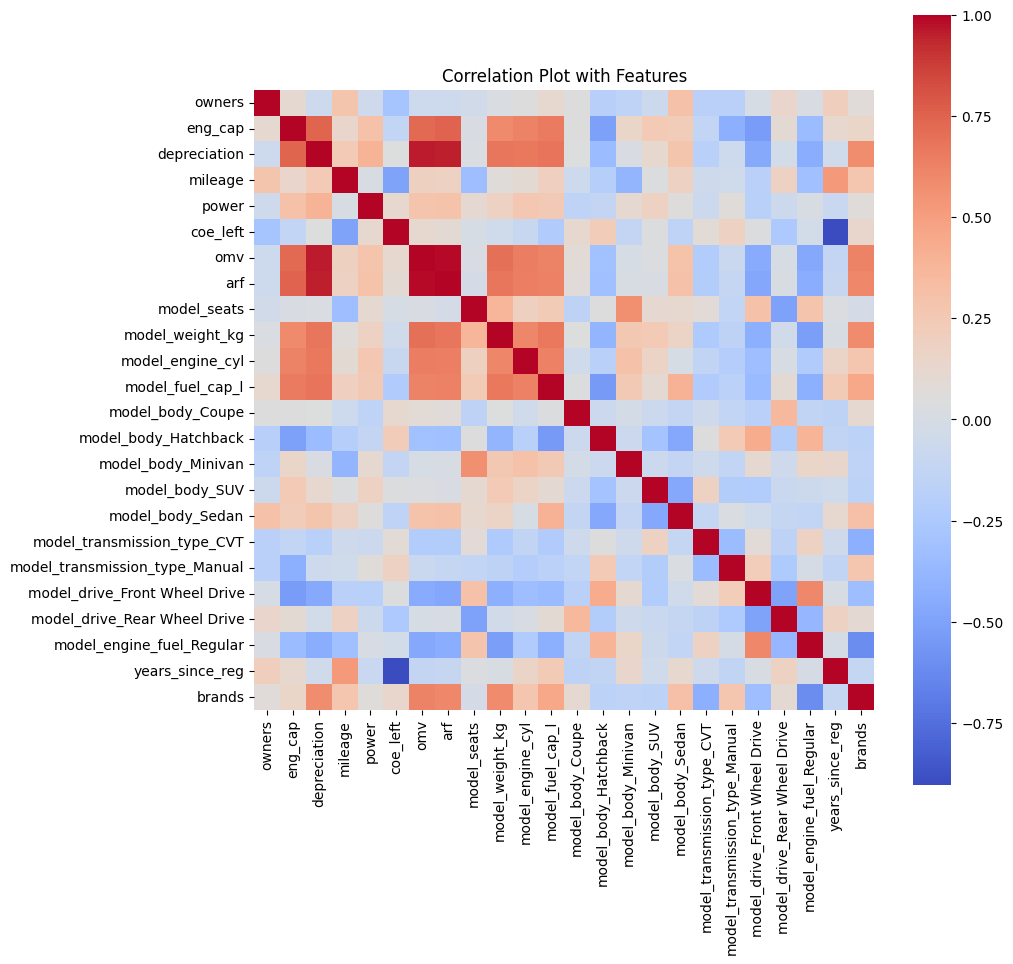

In [362]:
# plotting correlation heatmap between numeric variables

independent_vars = data.drop(columns=['price'])

correlation = independent_vars.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, cmap="coolwarm")
plt.title("Correlation Plot with Features")

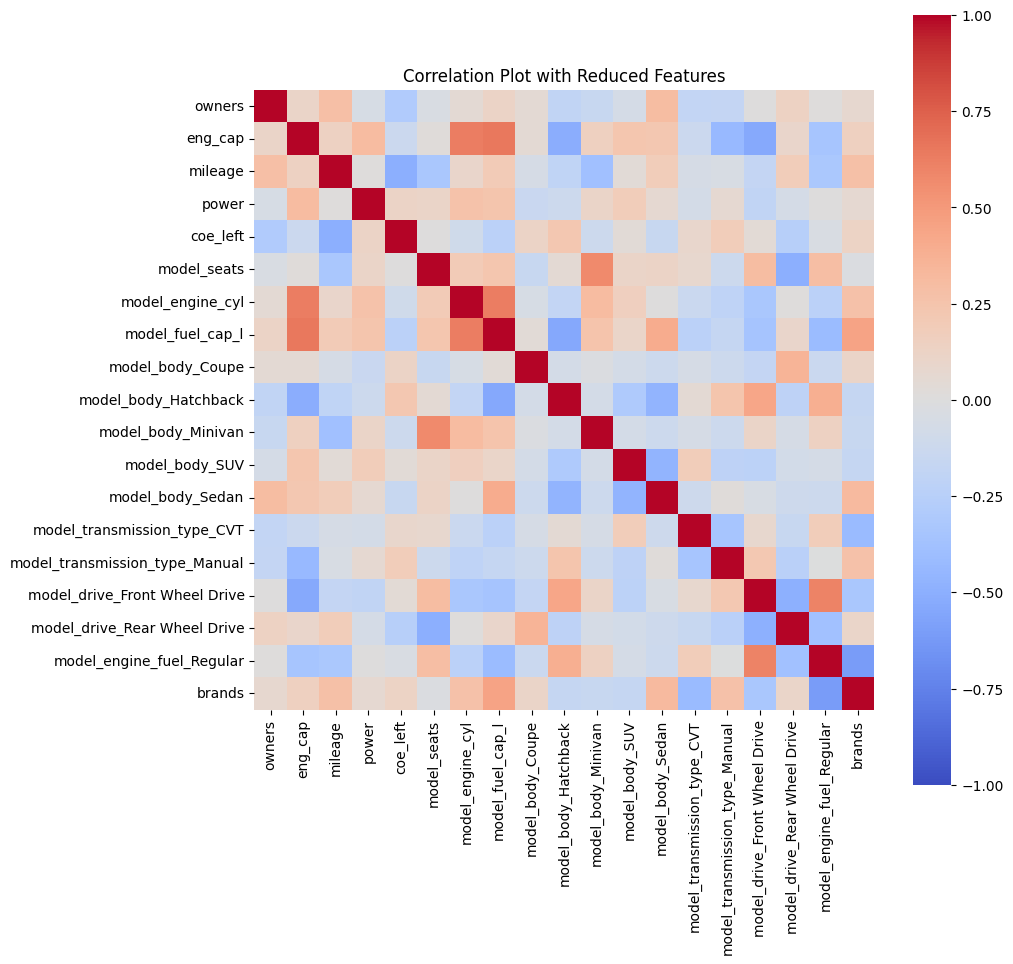

In [363]:
#identify pairs of highly correlated features
threshold = 0.7
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# remove these columns from the DataFrame
independent_vars = independent_vars.drop(columns=to_drop)

# calculate the corr again
corr_reduced = independent_vars.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_reduced, vmax=1, vmin=-1, square=True, cmap="coolwarm")
plt.title('Correlation Plot with Reduced Features')
plt.show()

In [364]:
# might change after combining with coe price
print(independent_vars.columns)
Y = data['price']

Index(['owners', 'eng_cap', 'mileage', 'power', 'coe_left', 'model_seats',
       'model_engine_cyl', 'model_fuel_cap_l', 'model_body_Coupe',
       'model_body_Hatchback', 'model_body_Minivan', 'model_body_SUV',
       'model_body_Sedan', 'model_transmission_type_CVT',
       'model_transmission_type_Manual', 'model_drive_Front Wheel Drive',
       'model_drive_Rear Wheel Drive', 'model_engine_fuel_Regular', 'brands'],
      dtype='object')


# Linear Regression

In [365]:
# split the data up for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 25905.868562901975
MSE: 1567306798.7389033
RMSE: 39589.2257911026
R^2: 0.22354519448059784
Adjusted R^2: 1.8627275616882246


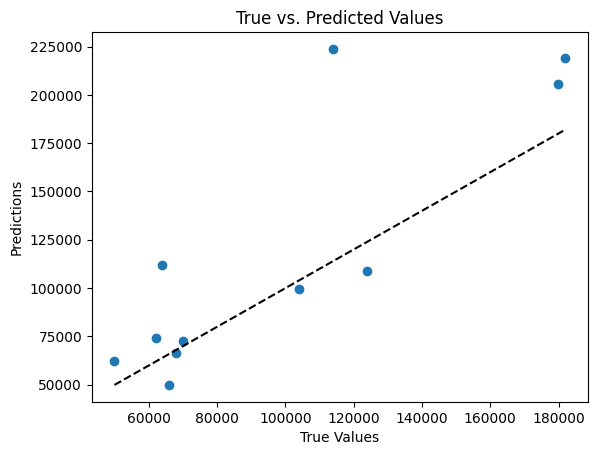

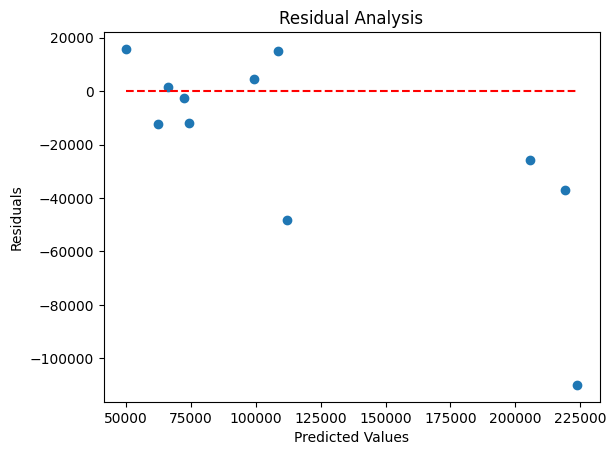

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_34628/1653121044.py:42: RuntimeWarning: overflow encountered in power
  linear_regressor_predicted['predicted_price'] = np.power(10, predicted_price_LR)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8,1.0,inf
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5,2.0,inf
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6,2.0,inf
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6,2.0,inf
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8,2.0,inf
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8,2.0,inf
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5,1.0,inf
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6,1.0,inf
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7,1.0,inf
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4,1.0,inf


In [366]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_LR_train, y_LR_train)
y_LR_pred = linear_regressor.predict(X_LR_test)

# Calculate R-squared
n_LR = X_LR_test.shape[0]  # number of observations
p_LR = X_LR_test.shape[1]  # number of features
mae_LR = mean_absolute_error(y_LR_test, y_LR_pred)
mse_LR = mean_squared_error(y_LR_test, y_LR_pred)
rmse_LR = mean_squared_error(y_LR_test, y_LR_pred, squared=False)
r2_LR = r2_score(y_LR_test, y_LR_pred)
adjusted_r2_LR = 1 - (1 - r2_LR) * ((n_LR - 1) / (n_LR - p_LR - 1))
print(f"MAE: {mae_LR}")
print(f"MSE: {mse_LR}")
print(f"RMSE: {rmse_LR}")
print(f"R^2: {r2_LR}")
print(f"Adjusted R^2: {adjusted_r2_LR}")

#plotting True VS Predicted
plt.scatter(y_LR_test, y_LR_pred)
plt.plot([y_LR_test.min(), y_LR_test.max()], [y_LR_test.min(), y_LR_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_LR = y_LR_test - y_LR_pred
plt.scatter(y_LR_pred, residuals_LR)
plt.hlines(y=0, xmin=y_LR_pred.min(), xmax=y_LR_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars 
predicted_price_LR = linear_regressor.predict(x)
linear_regressor_predicted = data.copy()
linear_regressor_predicted['predicted_price'] = np.power(10, predicted_price_LR)
linear_regressor_predicted

# Best Lasso

In [367]:
# split the data up for testing

X_Lasso_train, X_Lasso_test, y_Lasso_train, y_Lasso_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

/Users/isabel/opt/anaconda3/envs/IS3107/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+09, tolerance: 4.146e+06
  model = cd_fast.enet_coordinate_descent(
/Users/isabel/opt/anaconda3/envs/IS3107/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.616e+08, tolerance: 7.737e+06
  model = cd_fast.enet_coordinate_descent(
/Users/isabel/opt/anaconda3/envs/IS3107/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Best alpha: 100
MAE: 22913.618689709765
MSE: 1204053948.880883
RMSE: 34699.48052753648
R^2: 0.40350320979567356
Adjusted R^2: 1.6627742113381405


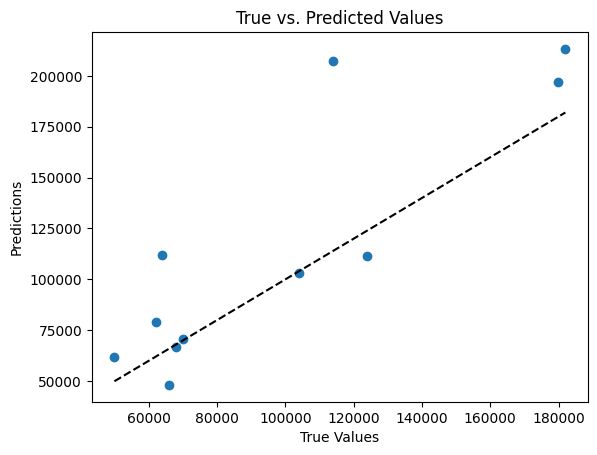

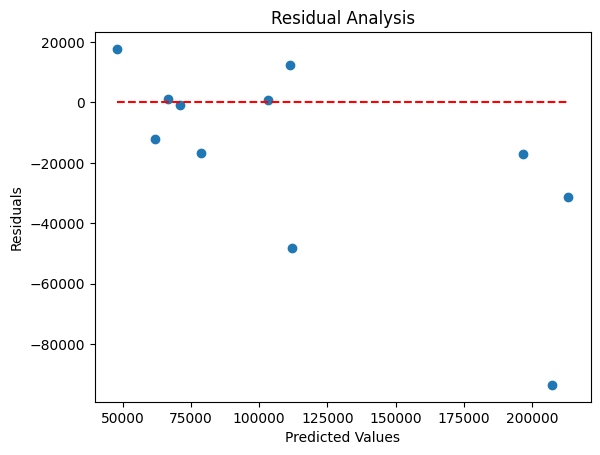

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_34628/3284264278.py:52: RuntimeWarning: overflow encountered in power
  lasso_predicted_results['predicted_price'] = np.power(10, predicted_price_Lasso)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8,1.0,inf
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5,2.0,inf
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6,2.0,inf
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6,2.0,inf
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8,2.0,inf
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8,2.0,inf
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5,1.0,inf
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6,1.0,inf
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7,1.0,inf
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4,1.0,inf


In [368]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


lasso = Lasso()
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#looping through to find best alpha value
grid_search = GridSearchCV(estimator=lasso, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_Lasso_train, y_Lasso_train)

lasso = grid_search.best_estimator_
y_Lasso_pred = lasso.predict(X_Lasso_test)
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Calculate R-squared
n_Lasso = X_Lasso_test.shape[0]  # number of observations
p_Lasso = X_Lasso_test.shape[1]  # number of features
mae_Lasso = mean_absolute_error(y_Lasso_test, y_Lasso_pred)
mse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred)
rmse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred, squared=False)
r2_Lasso = r2_score(y_Lasso_test, y_Lasso_pred)
adjusted_r2_Lasso = 1 - (1 - r2_Lasso) * ((n_Lasso - 1) / (n_Lasso - p_Lasso - 1))
print(f"MAE: {mae_Lasso}")
print(f"MSE: {mse_Lasso}")
print(f"RMSE: {rmse_Lasso}")
print(f"R^2: {r2_Lasso}")
print(f"Adjusted R^2: {adjusted_r2_Lasso}")

#plotting True VS Predicted
plt.scatter(y_Lasso_test, y_Lasso_pred)
plt.plot([y_Lasso_test.min(), y_Lasso_test.max()], [y_Lasso_test.min(), y_Lasso_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_Lasso = y_Lasso_test - y_Lasso_pred
plt.scatter(y_Lasso_pred, residuals_Lasso)
plt.hlines(y=0, xmin=y_Lasso_pred.min(), xmax=y_Lasso_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_Lasso = lasso.predict(x)
lasso_predicted_results = data.copy()
lasso_predicted_results['predicted_price'] = np.power(10, predicted_price_Lasso)
lasso_predicted_results

# Decision Tree

In [369]:
# split the data up for testing

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 53197.72727272727
MSE: 6194055325.181818
RMSE: 78702.32096438973
R^2: -2.068578549369045
Adjusted R^2: 4.409531721521161


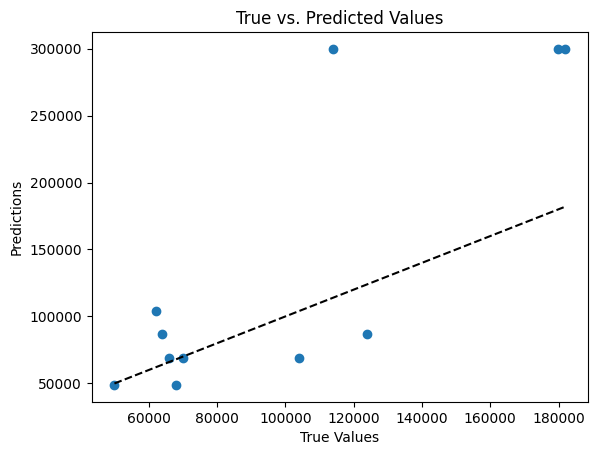

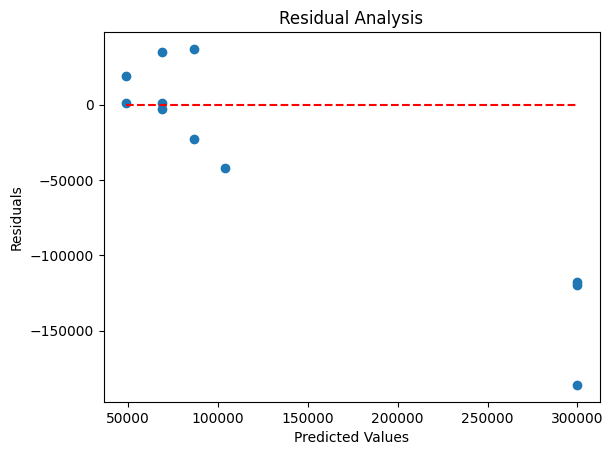

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_34628/2854259438.py:43: RuntimeWarning: overflow encountered in power
  dt_predicted['predicted_price'] = np.power(10, predicted_price_DT)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8,1.0,inf
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5,2.0,inf
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6,2.0,inf
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6,2.0,inf
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8,2.0,inf
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8,2.0,inf
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5,1.0,inf
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6,1.0,inf
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7,1.0,inf
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4,1.0,inf


In [370]:
from sklearn.tree import DecisionTreeRegressor


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_DT_train, y_DT_train)
y_DT_pred = dt_regressor.predict(X_DT_test)

#Calculating R Squared
n_DT = X_DT_test.shape[0]  # number of observations
p_DT = X_DT_test.shape[1]  # number of features
mae_DT = mean_absolute_error(y_DT_test, y_DT_pred)
mse_DT = mean_squared_error(y_DT_test, y_DT_pred)
rmse_DT = mean_squared_error(y_DT_test, y_DT_pred, squared=False)
r2_DT = r2_score(y_DT_test, y_DT_pred)
adjusted_r2_DT = 1 - (1 - r2_DT) * ((n_DT - 1) / (n_DT - p_DT - 1))
print(f"MAE: {mae_DT}")
print(f"MSE: {mse_DT}")
print(f"RMSE: {rmse_DT}")
print(f"R^2: {r2_DT}")
print(f"Adjusted R^2: {adjusted_r2_DT}")

#plotting True VS Predicted
plt.scatter(y_DT_test, y_DT_pred)
plt.plot([y_DT_test.min(), y_DT_test.max()], [y_DT_test.min(), y_DT_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_DT = y_DT_test - y_DT_pred
plt.scatter(y_DT_pred, residuals_DT)
plt.hlines(y=0, xmin=y_DT_pred.min(), xmax=y_DT_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_DT = dt_regressor.predict(x)
dt_predicted = data.copy()
dt_predicted['predicted_price'] = np.power(10, predicted_price_DT)
dt_predicted

# Random Forest

In [371]:
# split the data up for testing

X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 17492.879999999997
MSE: 475969186.1858362
RMSE: 21816.718043414236
R^2: 0.764201519325689
Adjusted R^2: 1.2619983118603455


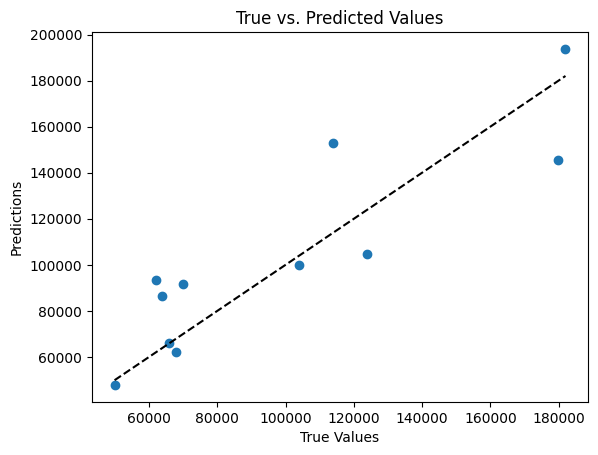

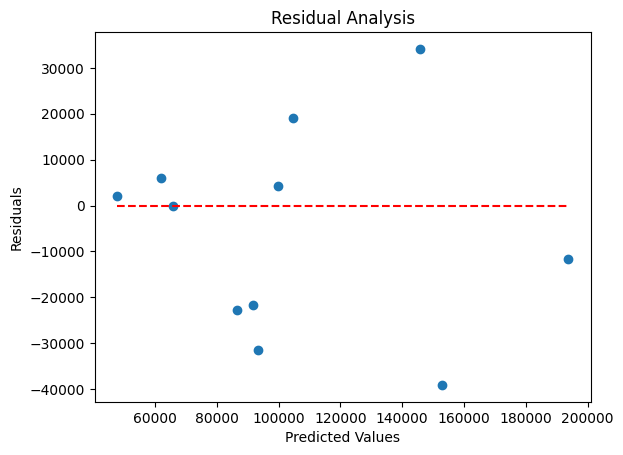

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_34628/1384493872.py:42: RuntimeWarning: overflow encountered in power
  rf_predicted['predicted_price'] = np.power(10, predicted_price_RF)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8,1.0,inf
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5,2.0,inf
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6,2.0,inf
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6,2.0,inf
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8,2.0,inf
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8,2.0,inf
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5,1.0,inf
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6,1.0,inf
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7,1.0,inf
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4,1.0,inf


In [372]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees
rf_regressor.fit(X_RF_train, y_RF_train)
y_RF_pred = rf_regressor.predict(X_RF_test)

# Calculating R-Squared
n_RF = X_RF_test.shape[0]  # number of observations
p_RF = X_RF_test.shape[1]  # number of features
mae_RF = mean_absolute_error(y_RF_test, y_RF_pred)
mse_RF = mean_squared_error(y_RF_test, y_RF_pred)
rmse_RF = mean_squared_error(y_RF_test, y_RF_pred, squared=False)
r2_RF = r2_score(y_RF_test, y_RF_pred)
adjusted_r2_RF = 1 - (1 - r2_RF) * ((n_RF - 1) / (n_RF - p_RF - 1))
print(f"MAE: {mae_RF}")
print(f"MSE: {mse_RF}")
print(f"RMSE: {rmse_RF}")
print(f"R^2: {r2_RF}")
print(f"Adjusted R^2: {adjusted_r2_RF}")

#plotting True VS Predicted
plt.scatter(y_RF_test, y_RF_pred)
plt.plot([y_RF_test.min(), y_RF_test.max()], [y_RF_test.min(), y_RF_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_RF = y_RF_test - y_RF_pred
plt.scatter(y_RF_pred, residuals_RF)
plt.hlines(y=0, xmin=y_RF_pred.min(), xmax=y_RF_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_RF = rf_regressor.predict(x)
rf_predicted = data.copy()
rf_predicted['predicted_price'] = np.power(10, predicted_price_RF)
rf_predicted

# Gradient Boosting

In [373]:
# split the data up for testing

X_GB_train, X_GB_test, y_GB_train, y_GB_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 31246.854879606526
MSE: 2004500602.875664
RMSE: 44771.64954383146
R^2: 0.006956310645961472
Adjusted R^2: 2.103381877060043


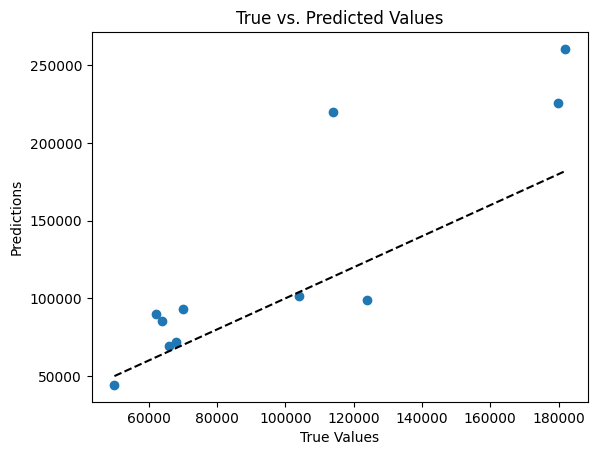

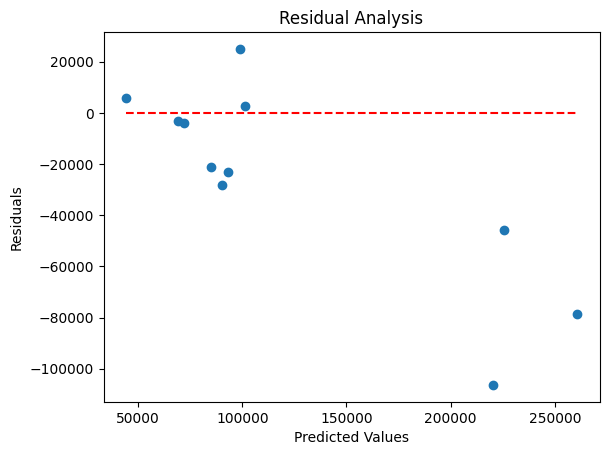

/var/folders/0r/ynlpb1xx2mz3qlbhfqx5f42m0000gn/T/ipykernel_34628/1410396179.py:42: RuntimeWarning: overflow encountered in power
  gb_predicted['predicted_price'] = np.power(10, predicted_price_GB)


,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,3,1998.0,36000.0,14468.0,125000.0,1210.0,1.80,18409.0,18409.0,5,1338.775510,4,45.0415,False,False,False,True,False,False,False,False,False,True,8,1.0,inf
1,1,1984.0,156999.0,23989.0,74000.0,1850.0,5.40,43623.0,53073.0,5,1839.909297,4,70.0225,False,False,False,True,False,False,True,False,False,False,5,2.0,inf
2,2,1499.0,94800.0,16860.0,103000.0,103.0,4.42,34636.0,40491.0,5,1606.802721,4,60.9385,False,False,False,True,False,False,False,True,False,False,6,2.0,inf
3,2,2998.0,182000.0,30837.0,113763.0,2650.0,4.40,68522.0,95340.0,5,1939.682540,6,65.1020,False,False,False,True,False,False,False,False,False,False,6,2.0,inf
4,2,1997.0,56800.0,21015.0,123000.0,1350.0,1.80,31174.0,35644.0,5,1827.664399,4,66.9945,False,False,False,True,False,False,False,False,True,False,8,2.0,inf
5,3,2979.0,113800.0,26740.0,115200.0,225.0,2.48,68263.0,94874.0,5,2351.473923,8,84.7840,False,False,False,True,False,False,False,False,False,False,8,2.0,inf
6,1,1797.0,87888.0,15818.0,49888.0,900.0,4.80,29140.0,22796.0,5,1496.598639,4,49.9620,False,False,False,True,False,True,False,True,False,True,5,1.0,inf
7,1,1496.0,66800.0,15390.0,43474.0,96.0,3.72,19116.0,19116.0,5,1322.902494,4,49.9620,False,False,False,True,False,False,True,True,False,True,6,1.0,inf
8,2,1580.0,56800.0,17012.0,111000.0,1036.0,3.20,27383.0,5000.0,5,1433.560091,4,45.0415,False,False,False,True,False,False,True,True,False,True,7,1.0,inf
10,1,1998.0,119800.0,16140.0,33000.0,1210.0,6.60,24615.0,26461.0,5,1465.759637,4,51.0975,False,False,False,True,False,False,False,True,False,True,4,1.0,inf


In [374]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)  # 100 trees
gb_regressor.fit(X_GB_train, y_GB_train)
y_GB_pred = gb_regressor.predict(X_GB_test)

# Calculating R-Squared
n_GB = X_GB_test.shape[0]  # number of observations
p_GB = X_GB_test.shape[1]  # number of features
mae_GB = mean_absolute_error(y_GB_test, y_GB_pred)
mse_GB = mean_squared_error(y_GB_test, y_GB_pred)
rmse_GB = mean_squared_error(y_GB_test, y_GB_pred, squared=False)
r2_GB = r2_score(y_GB_test, y_GB_pred)
adjusted_r2_GB = 1 - (1 - r2_GB) * ((n_GB - 1) / (n_GB - p_GB - 1))
print(f"MAE: {mae_GB}")
print(f"MSE: {mse_GB}")
print(f"RMSE: {rmse_GB}")
print(f"R^2: {r2_GB}")
print(f"Adjusted R^2: {adjusted_r2_GB}")

#plotting True VS Predicted
plt.scatter(y_GB_test, y_GB_pred)
plt.plot([y_GB_test.min(), y_GB_test.max()], [y_GB_test.min(), y_GB_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_GB = y_GB_test - y_GB_pred
plt.scatter(y_GB_pred, residuals_GB)
plt.hlines(y=0, xmin=y_GB_pred.min(), xmax=y_GB_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_GB = gb_regressor.predict(x)
gb_predicted = data.copy()
gb_predicted['predicted_price'] = np.power(10, predicted_price_GB)
gb_predicted

In [375]:
from sklearn.model_selection import cross_val_score

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# For regression, it's common to use negative mean squared error as the scoring method
scores = cross_val_score(gb_regressor, independent_vars, Y, cv=10, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()  # Negate to get positive MSE
rmse = mean_mse ** 0.5  # Calculate RMSE from MSE

print(f"Mean MSE from 10-fold CV: {mean_mse}")
print(f"Mean RMSE from 10-fold CV: {rmse}")


Mean MSE from 10-fold CV: 722715371.2397501
Mean RMSE from 10-fold CV: 26883.3660697419


The cross-validation results show a Mean MSE of approximately 0.0017 and a Mean RMSE of approximately 0.0415. These values are quite close to the ones previously reported from a single train-test split (MSE: 0.001674, RMSE: 0.0409), which suggests the model is performing consistently across different subsets of the data and is not likely to be overfitted